#  First validation of test2

Based on all three tests' results, the test2 has the best performance. Thus, we decide to repeat the test2's model two more times which verify the modle may work well on 30 classes.

The results of this repeat goes well.

In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GaussianNoise, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14699118327036049130
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2264907776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10900450880824840497
physical_device_desc: "device: 0, name: GeForce GTX 970M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
import tensorflow.keras.backend as K
K.clear_session()

In [4]:
nrow = 200
ncol = 200
nclass = 3
base_model = applications.VGG16(weights='imagenet', input_shape=(nrow,ncol,3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(2304, activation = 'relu')(x) # 18432/4
x = GaussianNoise(0.1)(x) # add noise to mitigate overfitting (regularization layer)
x = Dropout(0.5)(x)
x = Dense(288, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(nclass, activation='softmax', 
             kernel_initializer='random_uniform', 
             bias_initializer='random_uniform', 
             bias_regularizer=regularizers.l2(0.01), 
             name='predictions')(x) 
model = Model(inputs=base_model.input, outputs=pred)
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [6]:
train_data_dir = './images_train'
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 1616 images belonging to 3 classes.


In [7]:
test_data_dir = './images_test'
batch_size = 10
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 402 images belonging to 3 classes.


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [9]:
nepochs = 20  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    epochs=nepochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
162/162 [==============================] - 51s 316ms/step - loss: 0.9289 - acc: 0.5705 - val_loss: 0.7035 - val_acc: 0.7264
Epoch 2/20
162/162 [==============================] - 49s 303ms/step - loss: 0.7224 - acc: 0.6850 - val_loss: 0.5645 - val_acc: 0.7562
Epoch 3/20
162/162 [==============================] - 49s 300ms/step - loss: 0.6750 - acc: 0.7290 - val_loss: 0.7018 - val_acc: 0.6915
Epoch 4/20
162/162 [==============================] - 48s 299ms/step - loss: 0.6296 - acc: 0.7450 - val_loss: 0.5393 - val_acc: 0.7886
Epoch 5/20
162/162 [==============================] - 51s 315ms/step - loss: 0.5613 - acc: 0.7816 - val_loss: 0.5456 - val_acc: 0.7811
Epoch 6/20
162/162 [==============================] - 50s 306ms/step - loss: 0.5882 - acc: 0.7785 - val_loss: 0.4797 - val_acc: 0.8109
Epoch 7/20
162/162 [==============================] - 50s 309ms/step - loss: 0.5580 - acc: 0.7797 - val_loss: 0.5121 - val_acc: 0.7761
Epoch 8

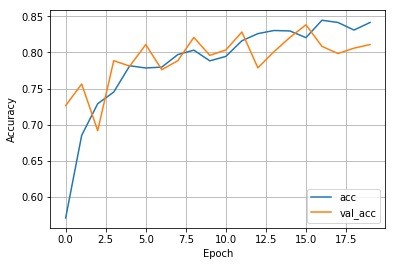

In [10]:
hist_his = hist.history
acc = hist_his['acc']
val_acc = hist_his['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc','val_acc'], loc = 4)

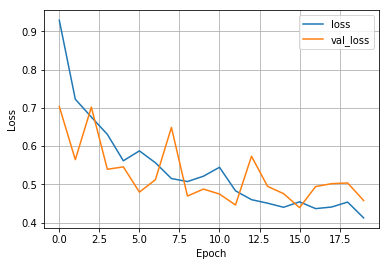

In [11]:
loss = hist_his['loss']
val_loss = hist_his['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc = 1)

In [12]:
print(loss)
print(val_loss)
print(acc)
print(val_acc)

[0.9289161065353615, 0.7224967200677879, 0.6759471297264099, 0.6306312879418382, 0.5615544472959372, 0.5874900020161035, 0.556419783779005, 0.5151083443018765, 0.5072679424308019, 0.5212524245944944, 0.5445805789423314, 0.4830270196947426, 0.45990993905960037, 0.45074576311883063, 0.44000948075721463, 0.45428610602301533, 0.43651072863526275, 0.4407050690088089, 0.45363716278594024, 0.4122254128826063]
[0.7035112217432116, 0.5645308351007904, 0.7017756362513798, 0.5393307526118871, 0.5456454886532411, 0.4796854878616769, 0.5120801929293609, 0.6487705882911275, 0.469417158241679, 0.4875728570651717, 0.47461483354975537, 0.44605547989287025, 0.5734203847624907, 0.49476630040785163, 0.4756545166416866, 0.43909876557385047, 0.4941506394889297, 0.5017719225185674, 0.5036047856982161, 0.4576926866500843]
[0.57054454, 0.68502474, 0.7289604, 0.7450495, 0.7815594, 0.77846533, 0.77970296, 0.7970297, 0.8032178, 0.7883663, 0.7945545, 0.8162129, 0.8261139, 0.8304455, 0.8298267, 0.82054454, 0.844678